In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from typing import Optional
from torch.utils.data import DataLoader, TensorDataset

We write classes for linear and singular models that we are going to use train SGD

In [55]:
class SingModel(torch.nn.Module):
    def __init__(self, w0:float, d1:int, d2:int, in_features:int, cst: float, out_features:int,w_init: Optional[Tensor] = None) -> None:
         super(SingModel, self).__init__()
         self.w0 = w0
         self.d1 = d1
         self.d2 = d2
         self.cst = cst
         if w_init is not None:
            self.weight = torch.nn.Parameter(w_init)
         else:
            self.weight = torch.nn.Parameter(torch.randn((out_features, in_features)))

         
    def forward(self, input:Tensor):
        # Chose cst1 and cst2 such that K(1) = 0 and K'(1) = cst
        cst1 = (self.cst/16)**(1/3)
        cst2 = -self.cst/4 + (self.cst/16)**(4/3)
        sing1 = (self.weight + self.w0)**self.d1
        sing2 = torch.sqrt((self.weight - self.w0 - cst1)**(2*self.d2) - cst2)
        return input * sing1 * sing2 

# Defining the Linear Model
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(1, 1)
        # Random weight initialization
        self.linear.weight.data.normal_()
    def forward(self, x):
        return self.linear(x)
    
# Training model

def train_model(model, data_loader, w_init: Optional[Tensor] = None, 
                linear=True, num_epochs = 1000, lr=0.01, momentum=0.9):
    # Loss tracking
    running_loss = []

    # Tracking weights
    if w_init is None:
         running_weight = []
    else:
         running_weight = [w_init.item()]

    # Loss and Optimizer
    loss_function = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), momentum=momentum, lr=lr)

    # Training the Model
    for epoch in range(num_epochs):
        #epoch_loss = 0.0
        for batch_x, batch_y in data_loader:
            # Forward pass
            y_pred = model(batch_x)
            loss = loss_function(y_pred, batch_y)

            # Backward pass and optimization
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Tracking the cumulative loss for the current epoch
            #epoch_loss += loss.item()
            running_loss.append(loss.item())
            if linear == True:
                current_weight = model.linear.weight.item()
                running_weight.append(current_weight)
            else:
                current_weight = model.weight.item() 
                running_weight.append(current_weight)
        # Tracking loss and weight along epochs
        # Calculate average loss for the current epoch
        #avg_epoch_loss = epoch_loss / len(data_loader)
        #running_loss.append(avg_epoch_loss)
        #if linear == True:
        #    current_weight = model.linear.weight.item()
        #else:
        #    current_weight = model.weight.item() 
        #running_weight.append(current_weight)
        if epoch % 10 == 0:
                        print(f'Epoch {epoch}, Loss: {loss.item()}, w: {current_weight}')
    return running_loss, running_weight

# Plot loss curve

def plot_loss_curve(loss_values):
    plt.plot(loss_values)
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

# Plot loss landscape

def plot_loss_landscape(model, x_data, y_data,
                        weight_range, running_weight, linear=False):

    # Computing the loss for each weight value in the range
    loss_landscape = []
    loss_function = nn.MSELoss()

    for weight in weight_range:
        # Updating the model's weight and fixed bias
        if linear == True:
            model.linear.weight.data.fill_(weight)
        else:
            model.weight.data.fill_(weight) 
        
        # Forward pass with the updated weight
        y_pred = model(x_data)
        
        # Computing the loss
        loss = loss_function(y_pred, y_data)
        loss_landscape.append(loss.item())

    # Plotting the loss landscape
    
    plt.plot(weight_range, loss_landscape, label='Loss Landscape')

    # Plotting the trajectory of the weights during training
    plt.plot(running_weight, [loss_landscape[np.argmin(np.abs(weight_range - w))] for w in running_weight], 'o-', label='Training Path', markersize=3)
    plt.title('Weight Dynamics on Loss Landscape')
    plt.yscale("log")
    plt.xlabel('Weight')
    plt.ylabel('Loss')
    plt.legend()


Train a Linear model and visualise the loss curve and visualise the training dynamics on the loss landscape (for sanity check)

Epoch 0, Loss: 0.7453652024269104, w: 0.03190596029162407
Epoch 10, Loss: 0.9869140386581421, w: 0.012741617858409882
Epoch 20, Loss: 1.0611329078674316, w: -0.09846437722444534
Epoch 30, Loss: 1.6814130544662476, w: -0.07183529436588287
Epoch 40, Loss: 0.9524725675582886, w: -0.07972194999456406
Epoch 50, Loss: 1.6591265201568604, w: 0.020380711182951927
Epoch 60, Loss: 0.713718593120575, w: 0.09421015530824661
Epoch 70, Loss: 0.831896185874939, w: 0.07984668016433716
Epoch 80, Loss: 0.3263161778450012, w: 0.21139514446258545
Epoch 90, Loss: 0.7900863885879517, w: 0.03342674672603607


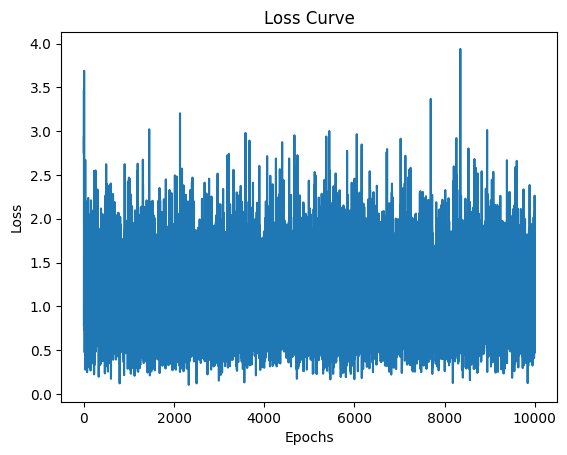

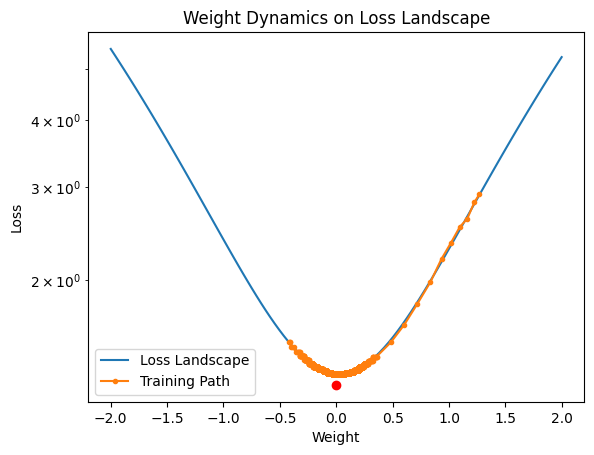

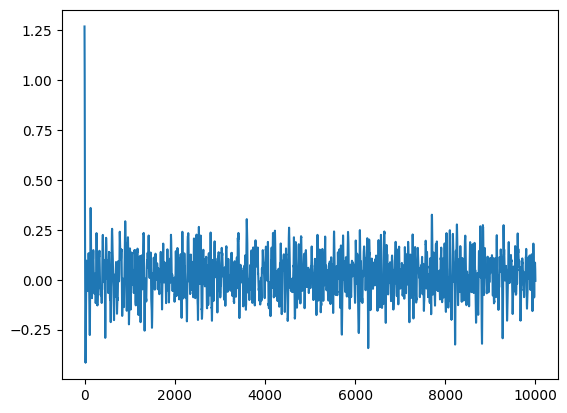

In [58]:
from torch.distributions import Cauchy 

# Parameters
torch.manual_seed(42) # for reproducibility
num_samples = 1000
num_epochs = 100
batch_size = 10
lr = 0.01
momentum = 0.9

x_data = torch.normal(0, 1, (num_samples, 1))
y_data = torch.normal(0, 1, (num_samples, 1))
dataset = TensorDataset(x_data, y_data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train function
model = LinearModel()
running_loss, running_weight =  train_model(model, data_loader, num_epochs = num_epochs, lr=lr, momentum=momentum)
plot_loss_curve(running_loss)

# Plot loss landscape
weight_range = np.linspace(-2, 2, 100)
model = LinearModel()
plt.figure()
plot_loss_landscape(model, x_data, y_data, 
                        weight_range, running_weight, linear=True)
plt.plot(running_weight[0],'ro')
plt.plot(running_weight[-1], 'o')
plt.show()
plt.plot(running_weight)


In [50]:
print(len(running_weight))

0


Train a singular model, plot loss curve and loss landscape

Epoch 0, Loss: 0.31675589084625244, w: -1.0601813793182373
Epoch 10, Loss: 0.9417706727981567, w: 1.0356696844100952
Epoch 20, Loss: 1.2307900190353394, w: 1.0426957607269287
Epoch 30, Loss: 1.257278561592102, w: 1.039553165435791
Epoch 40, Loss: 1.019188642501831, w: 1.0381187200546265
Epoch 50, Loss: 1.5657925605773926, w: 1.0358140468597412
Epoch 60, Loss: 1.526655912399292, w: 1.032442331314087
Epoch 70, Loss: 0.8151845932006836, w: 1.055198311805725
Epoch 80, Loss: 1.4212805032730103, w: 1.0290725231170654
Epoch 90, Loss: 1.3898732662200928, w: 1.0411794185638428


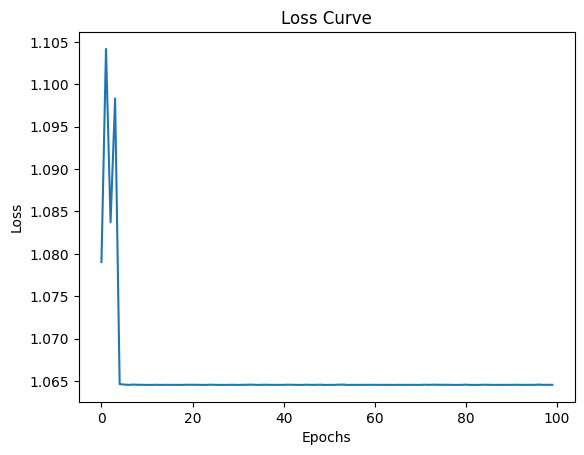

-1.2000000476837158


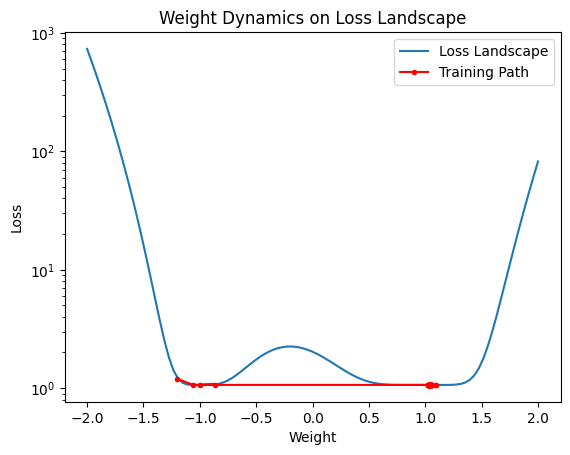

Text(0.5, 0, 'epochs')

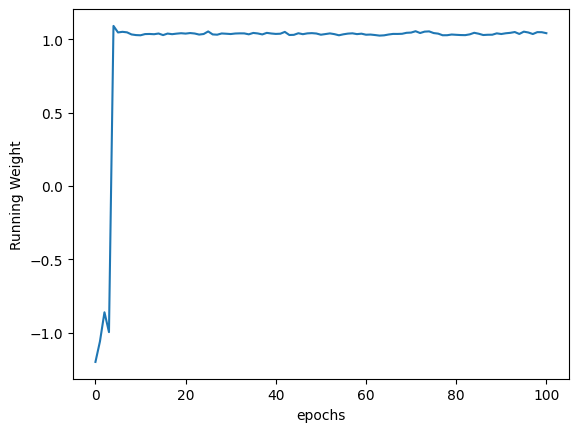

In [9]:
from torch.distributions import Cauchy 
from torch.distributions import StudentT

# Noise
#StudentT(df=1,loc=0,scale=1).sample((batch_size,1))
#torch.normal(0, 1, (batch_size, 1))
# Pramaters
torch.manual_seed(42) # for reproducibility
lr = 0.01
w_init = -1.2
num_epochs = 100
num_samples = 1000
batch_size = 5
cst = 0
momentum = 0.9

# Generate data
w_init = torch.Tensor([[w_init]])
torch.manual_seed(42) # for reproducibility
x_data = torch.normal(0, 1, (num_samples, 1))
y_data = torch.normal(0, 1, (num_samples, 1))
dataset = TensorDataset(x_data, y_data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training
model = SingModel(w0=1.0, d1=2, d2=3, in_features=1, out_features=1, 
                  cst=cst, w_init=w_init)
loss_values, weights_over_epochs =  train_model(model, data_loader, w_init=w_init,linear=False, num_epochs = num_epochs, lr=lr, momentum=momentum)
plot_loss_curve(loss_values)
print(weights_over_epochs[0])

# Plot loss landscape
weight_range = np.linspace(-2, 2, 100)
model = SingModel(w0=1.0, d1=2, d2=3, in_features=1, out_features=1, 
                  cst=cst, w_init=w_init)  # create a model instance
plot_loss_landscape(model, x_data, y_data,
                        weight_range, weights_over_epochs, linear=False)
plt.plot(weights_over_epochs)
plt.ylabel("Running Weight")
plt.xlabel("epochs")

Run different experiments

Epoch 0, Loss: 0.3146088719367981, w: 0.88904869556427
Epoch 10, Loss: 0.9347065687179565, w: 0.8835703134536743
Epoch 20, Loss: 1.3138400316238403, w: 0.8835701942443848
Epoch 30, Loss: 1.2920362949371338, w: 0.8835701942443848
Epoch 40, Loss: 0.9886821508407593, w: 0.8835701942443848
Epoch 50, Loss: 1.4141957759857178, w: 0.8835701942443848
Epoch 60, Loss: 1.6333410739898682, w: 0.8835701942443848
Epoch 70, Loss: 0.827716052532196, w: 0.8835701942443848
Epoch 80, Loss: 1.376038908958435, w: 0.8835701942443848
Epoch 90, Loss: 1.3800122737884521, w: 0.8835701942443848


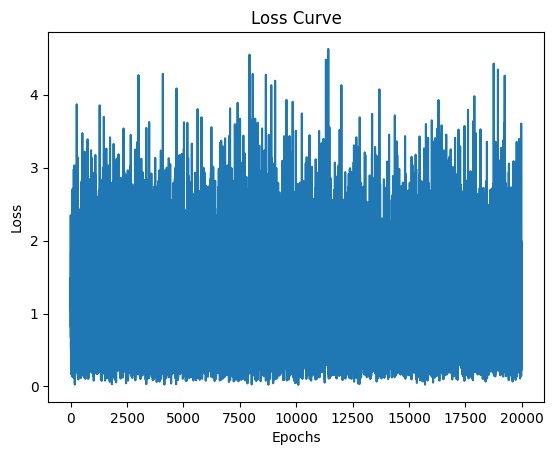

1.5


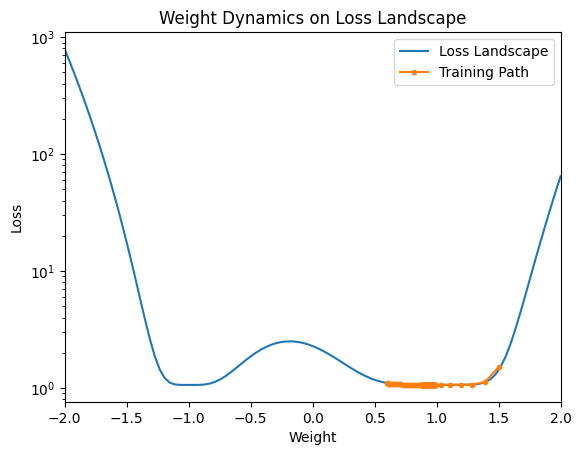

(0.5582553774118424, 1.5448449820280075)

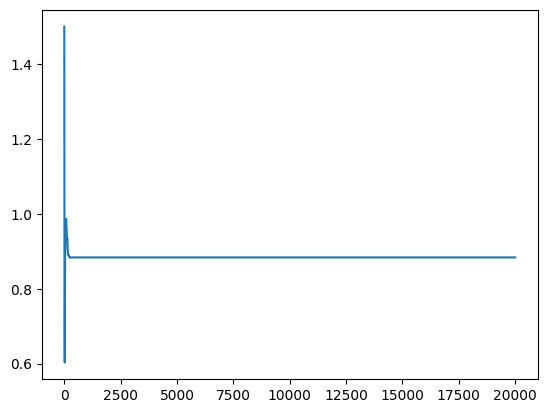

In [73]:
from torch.distributions import Cauchy 
from torch.distributions import StudentT

# Noise
#StudentT(df=1,loc=0,scale=1).sample((batch_size,1))
#torch.normal(0, 1, (batch_size, 1))

# Pramaters
torch.manual_seed(42) # for reproducibility
lr = 0.01
w_init = 1.5
batch_size = 5
momentum = 0.9
cst = 0.001

num_epochs = 100
num_samples = 1000

# Generate data
w_init = torch.Tensor([[w_init]])
torch.manual_seed(42) # for reproducibility
x_data = torch.normal(0, 1, (num_samples, 1))
y_data = torch.normal(0, 1, (num_samples, 1))
dataset = TensorDataset(x_data, y_data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training
model = SingModel(w0=1.0, d1=2, d2=3, in_features=1, out_features=1, cst=cst, w_init=w_init)

loss_values, weights_over_epochs =  train_model(model, data_loader, w_init=w_init,linear=False, num_epochs = num_epochs, lr=lr, momentum=momentum)
plot_loss_curve(loss_values)
print(weights_over_epochs[0])

# Plot loss landscape
weight_range = np.linspace(-2, 2, 100)
model = SingModel(w0=1.0, d1=2, d2=3, in_features=1, out_features=1, cst=cst, w_init=w_init)  # create a model instance
plt.figure()
plot_loss_landscape(model, x_data, y_data,
                        weight_range, weights_over_epochs, linear=False)
#plt.axhline(y=np.exp(cst), color ='black')
plt.xlim((-2,2))
plt.show()

plt.plot(weights_over_epochs)
plt.ylim()

In [24]:
cst

0.1